In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import os
print(os.listdir("."))

['DOHMH_New_York_City_Restaurant_Inspection_Results_1_of_6.csv', '.DS_Store', 'DOHMH_New_York_City_Restaurant_Inspection_Results_6_of_6.csv', 'README.md', 'Submissions', 'Yves_Greatti_DC1.ipynb', 'DOHMH_New_York_City_Restaurant_Inspection_Results_3_of_6.csv', 'DOHMH_New_York_City_Restaurant_Inspection_Results_2_of_6.csv', '.ipynb_checkpoints', 'DOHMH_New_York_City_Restaurant_Inspection_Results_4_of_6.csv', 'DOHMH_New_York_City_Restaurant_Inspection_Results_5_of_6.csv', 'Restaurant_Inspection_Open_Data_Dictionary_082214.xlsx']


# NYC Restaurant Analysis

In [3]:
restaurants = []
prefix  = 'DOHMH_New_York_City_Restaurant_Inspection_Results_'
postfix = '_of_6.csv'
for i in range(1,7):
    filename = prefix + str(i) + postfix
    df_train = pd.read_csv(filename)
    restaurants.append(df_train)
data_df = pd.concat(restaurants, axis=0)
data_df = data_df.reset_index().drop(columns=['index'])
data_df.shape

(399918, 19)

In [4]:
data_df.dtypes

Unnamed: 0                 int64
CAMIS                      int64
DBA                       object
BORO                      object
BUILDING                  object
STREET                    object
ZIPCODE                  float64
PHONE                     object
CUISINE DESCRIPTION       object
INSPECTION DATE           object
ACTION                    object
VIOLATION CODE            object
VIOLATION DESCRIPTION     object
CRITICAL FLAG             object
SCORE                    float64
GRADE                     object
GRADE DATE                object
RECORD DATE               object
INSPECTION TYPE           object
dtype: object

In [5]:
data_df.head(3)

,Unnamed: 0,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,0,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,06/15/2015,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,30.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection
1,1,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,11/25/2014,Violations were cited in the following area(s).,20F,Current letter grade card not posted.,Not Critical,NaN,NaN,NaN,08/28/2017,Administrative Miscellaneous / Initial Inspection
2,2,50046354,VITE BAR,QUEENS,2507,BROADWAY,11106.0,3478134702,Italian,10/03/2016,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,2.0,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection


In [6]:
data_df = data_df[data_df.columns.drop(list(data_df.filter(regex='Unnamed')))]
data_df.shape

(399918, 18)

In [7]:
data_df.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE'],
      dtype='object')

In [8]:
categorical_features = data_df.select_dtypes(include=[np.object])
categorical_features.columns

Index(['DBA', 'BORO', 'BUILDING', 'STREET', 'PHONE', 'CUISINE DESCRIPTION',
       'INSPECTION DATE', 'ACTION', 'VIOLATION CODE', 'VIOLATION DESCRIPTION',
       'CRITICAL FLAG', 'GRADE', 'GRADE DATE', 'RECORD DATE',
       'INSPECTION TYPE'],
      dtype='object')

In [9]:
# checking missing data in data 
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
GRADE DATE,207098,51.785116
GRADE,204505,51.136733
SCORE,23214,5.804690
VIOLATION DESCRIPTION,6979,1.745108
VIOLATION CODE,6504,1.626333


Most of the data missing is related to grades, which means we need to use other variables to evaluate quality of the food. This is confirmed by the 'missing' plot.

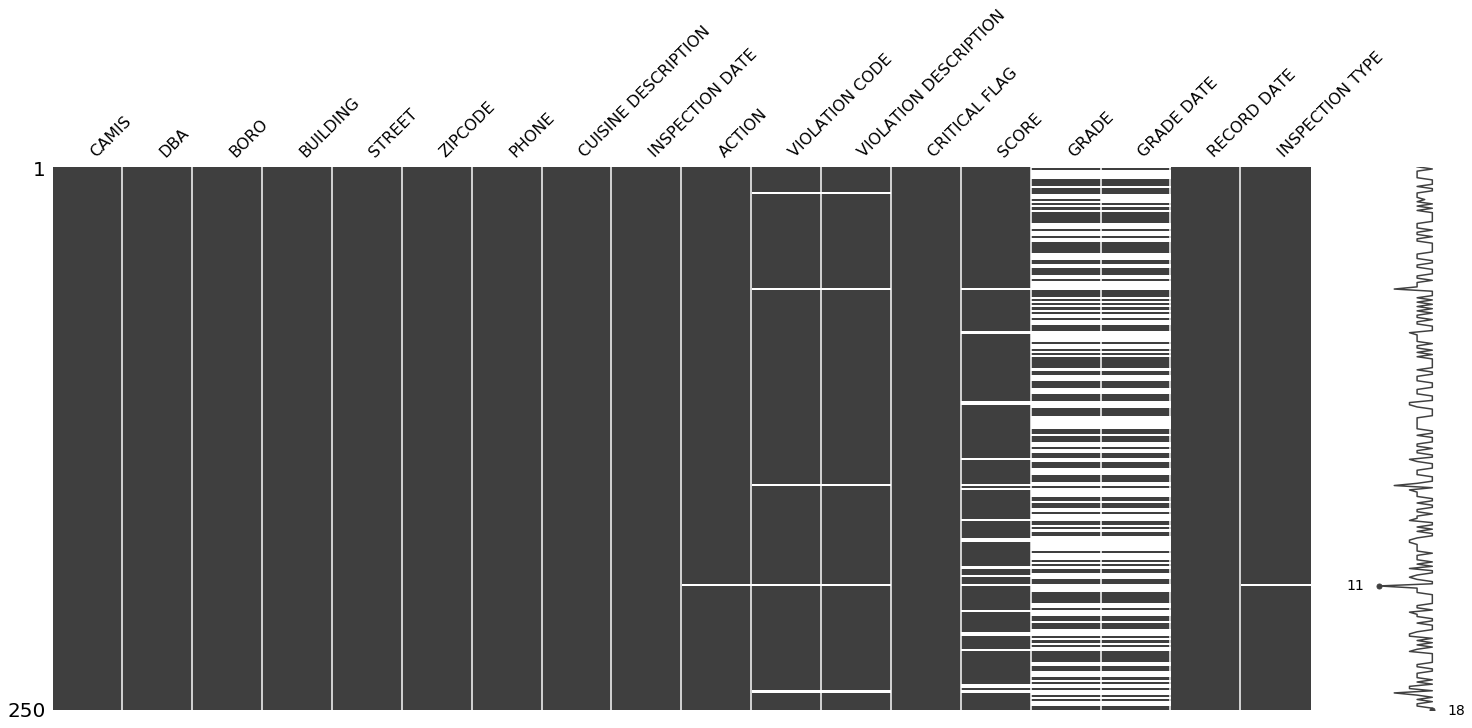

In [10]:
msno.matrix(data_df.sample(250))

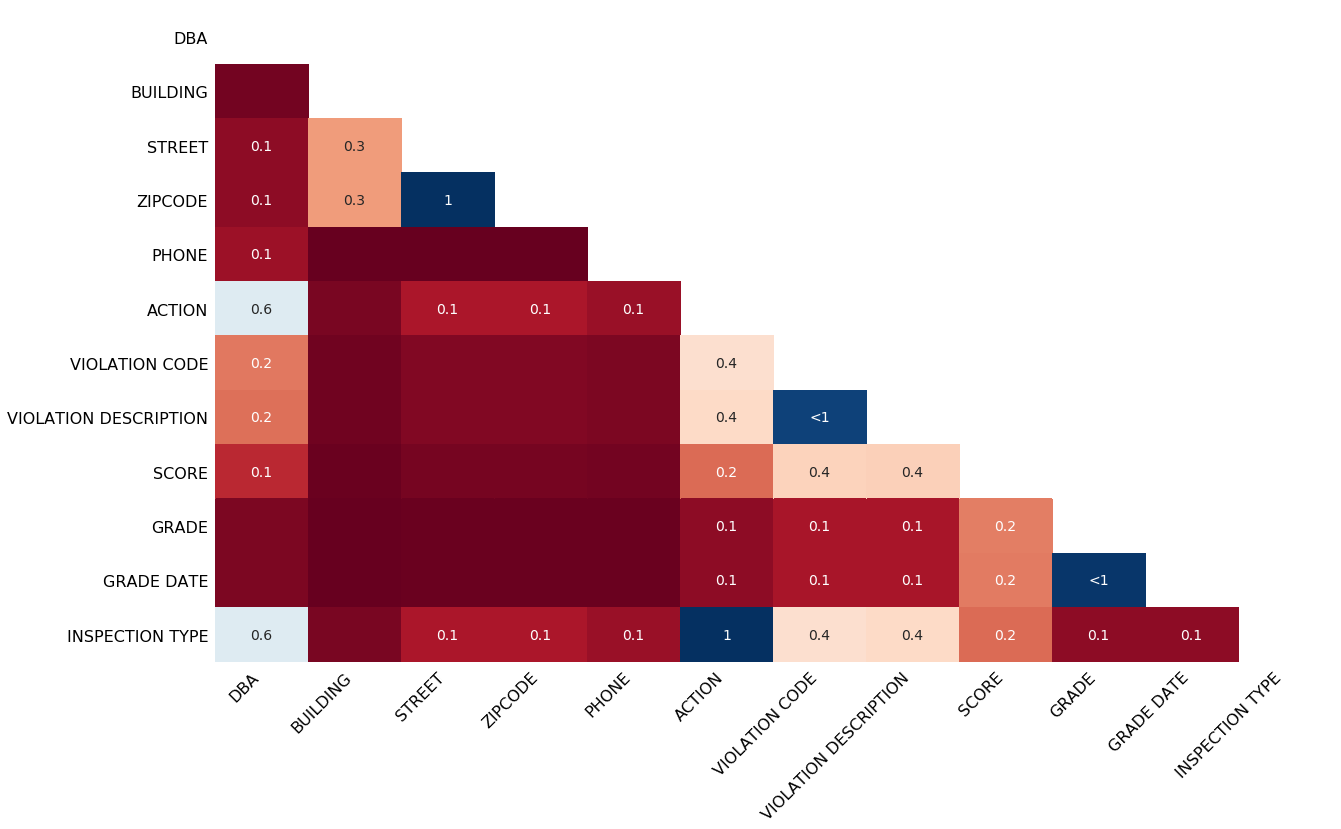

In [11]:
msno.heatmap(data_df)

Correlations of interest:
- Inspection type and action
- violation description and violation code

Let split the violation code into two features: level and type. We also format the dates and remove spaces between column names

In [12]:
def level_code(row):
    if type(row) == float: return 99, 'No'
    return int(row[:2]), row[2]
data_df['VIO_LVL'],data_df['VIO_TYPE'] = zip(*data_df['VIOLATION CODE'].apply(lambda row: level_code(row)))
# Label encoding the violation
data_df['VIO_CAT']  = data_df['VIO_LVL'].astype(str)
data_df['VIO_CAT']  = data_df['VIO_CAT'] + data_df['VIO_TYPE']
data_df["VIO_CAT"] = data_df["VIO_CAT"].astype('category')
data_df["VIO_CAT"] = data_df["VIO_CAT"].cat.codes

data_df['RECORD_DATE'] = pd.to_datetime(data_df['RECORD DATE'], format = '%m/%d/%Y', errors='coerce')
data_df['INSPECTION_DATE'] = pd.to_datetime(data_df['INSPECTION DATE'], format = '%m/%d/%Y', errors='coerce')
data_df['GRADE_DATE'] = pd.to_datetime(data_df['GRADE DATE'], format = '%m/%d/%Y', errors='coerce')
data_df.drop(['RECORD DATE', 'INSPECTION DATE', 'GRADE DATE'], axis = 1, inplace = True)
#data_df.drop(['VIOLATION CODE','RECORD DATE', 'INSPECTION DATE', 'GRADE DATE'], axis = 1, inplace = True)

data_df.columns = ['_'.join(x.split()) for x in data_df.columns]
data_df.head(3)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,ACTION,VIOLATION_CODE,...,CRITICAL_FLAG,SCORE,GRADE,INSPECTION_TYPE,VIO_LVL,VIO_TYPE,VIO_CAT,RECORD_DATE,INSPECTION_DATE,GRADE_DATE
0,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,Violations were cited in the following area(s).,02B,...,Critical,30.0,NaN,Cycle Inspection / Initial Inspection,2,B,42,2017-08-28,2015-06-15,NaT
1,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,Violations were cited in the following area(s).,20F,...,Not Critical,NaN,NaN,Administrative Miscellaneous / Initial Inspection,20,F,34,2017-08-28,2014-11-25,NaT
2,50046354,VITE BAR,QUEENS,2507,BROADWAY,11106.0,3478134702,Italian,Violations were cited in the following area(s).,10F,...,Not Critical,2.0,NaN,Pre-permit (Operational) / Initial Inspection,10,F,5,2017-08-28,2016-10-03,NaT


# Violation analysis

We plot histograms of the violation levels and types.

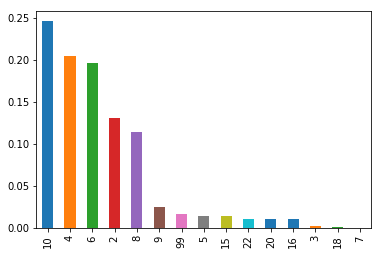

In [13]:
(data_df['VIO_LVL'].value_counts()/ len(data_df)).plot.bar()

Most of the violations are of levels: 10,4,6 and 2.

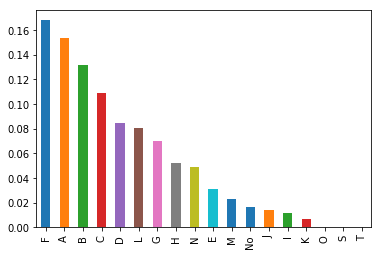

In [14]:
(data_df['VIO_TYPE'].value_counts()/ len(data_df)).plot.bar()

Most of the violations are: 'F', 'A', 'B', 'C', 'D', 'L', 'G', 'H' and 'N'.
Some of the violations are 'No', meaning no violation.

In [15]:
data_df.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE_DESCRIPTION', 'ACTION', 'VIOLATION_CODE',
       'VIOLATION_DESCRIPTION', 'CRITICAL_FLAG', 'SCORE', 'GRADE',
       'INSPECTION_TYPE', 'VIO_LVL', 'VIO_TYPE', 'VIO_CAT', 'RECORD_DATE',
       'INSPECTION_DATE', 'GRADE_DATE'],
      dtype='object')

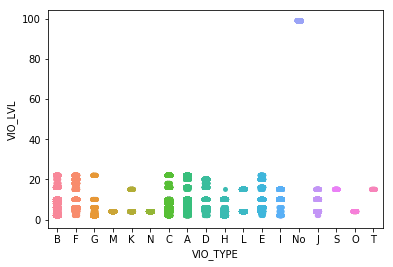

In [16]:
# u, inv = np.unique(data_df['VIO_TYPE'], return_inverse=True) 
# plt.scatter(inv, data_df['VIO_LVL'])
# plt.xticks(range(len(u)),u)
# plt.margins(x=0.5)
sns.stripplot(x="VIO_TYPE", y="VIO_LVL", data=data_df);

Violations levels are between 0 and 20 and spanned any violation types.

# Grades analysis

In [17]:
data_df.GRADE.value_counts()/len(data_df)*100

A                 38.556404
B                  7.042944
C                  1.748358
Not Yet Graded     0.649633
Z                  0.526108
P                  0.339820
Name: GRADE, dtype: float64

Among the existing grades, most of the grades are A and the rest of meaningful grades are B and C.

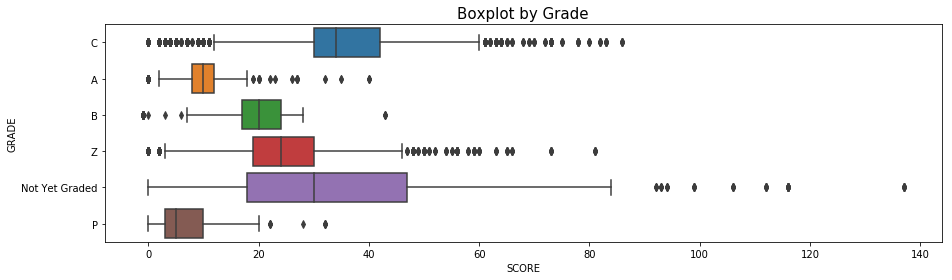

In [18]:
# First drop few nan scores

clean_scores = data_df.dropna(axis=0, subset=['SCORE']) 

# Lets look at scores by grades
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
sns.boxplot(clean_scores.SCORE, clean_scores.GRADE)
plt.title('Boxplot by Grade', fontsize = 15);

'A' and 'P' grades are related to scores between 0 and 20.
Scores between 20 and 40 are related to 'B' and 'Z' grades.
The higher the score the higher the grades alphabetically.

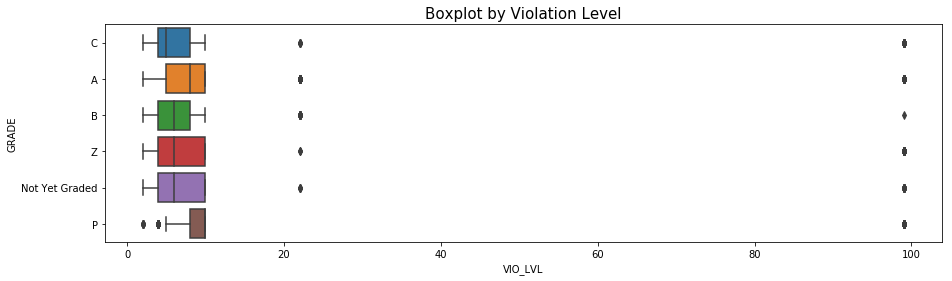

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
sns.boxplot(clean_scores.VIO_LVL, clean_scores.GRADE)
plt.title('Boxplot by Violation Level', fontsize = 15);

Violations levels  are the same cross grades.

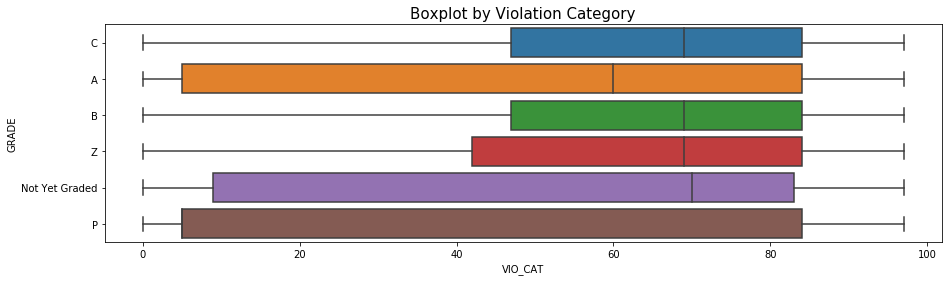

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
sns.boxplot(clean_scores.VIO_CAT, clean_scores.GRADE)
plt.title('Boxplot by Violation Category', fontsize = 15);

A grade spans any violation category, B and C grades are related to violation in categories between 50 and 80.

# Analysis of the critical flag

Most of the restaurants have A's. Few restaurants are not yet graded.

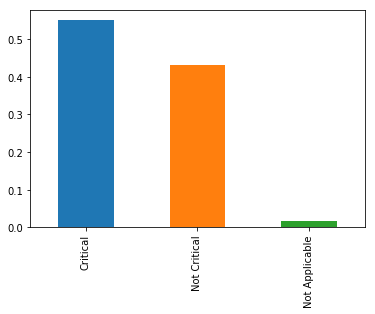

In [21]:
(data_df['CRITICAL_FLAG'].value_counts()/ len(data_df)).plot.bar();

We may drop any row with critical flag being 'Not Applicable'.

# Scores analysis

In [22]:
clean_scores['SCORE'].describe()

count    376704.000000
mean         18.910181
std          12.958955
min          -2.000000
25%          11.000000
50%          15.000000
75%          24.000000
max         151.000000
Name: SCORE, dtype: float64

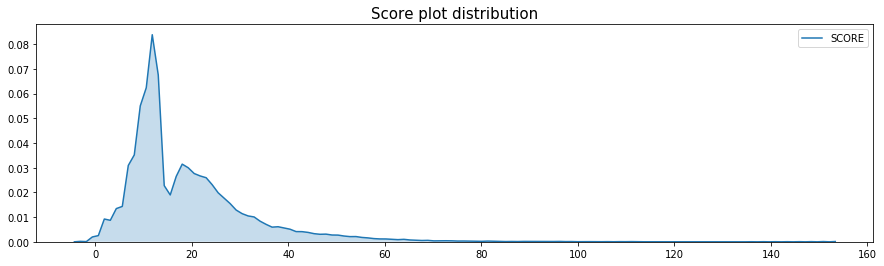

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
#sns.violinplot(clean_scores.SCORE)
sns.kdeplot(clean_scores.SCORE, shade=True)
plt.title("Score plot distribution", fontsize=15);


Most of the scores are between 0 and 80.

In [24]:
less_than_80_scores = clean_scores['SCORE'] < 80
clean_scores = clean_scores[less_than_80_scores]

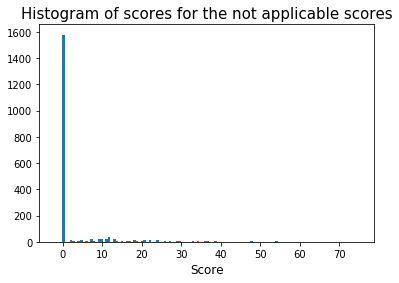

In [25]:
not_applicable_scores = clean_scores.loc[clean_scores['CRITICAL_FLAG'] == 'Not Applicable']
plt.hist(not_applicable_scores['SCORE'], bins=120)
plt.title("Histogram of scores for the not applicable scores", fontsize=15)
plt.xlabel('Score', fontsize = 12);

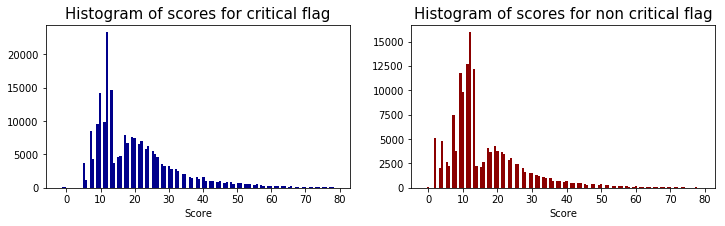

In [26]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 3))
not_critical_scores = clean_scores.loc[clean_scores['CRITICAL_FLAG'] == 'Not Critical']
critical_scores = clean_scores.loc[clean_scores['CRITICAL_FLAG'] == 'Critical']
axarr[0].hist(critical_scores['SCORE'], bins=120, color='darkblue')
axarr[0].set_title('Histogram of scores for critical flag', fontsize=15)
axarr[0].set_xlabel('Score')
axarr[1].hist(not_critical_scores['SCORE'], bins=120, color='darkred')
axarr[1].set_title('Histogram of scores for non critical flag', fontsize=15)
axarr[1].set_xlabel('Score');

It does not seem there are any correlations between the critical flag and the scores.

# Borough Analysis

In [27]:
data_df.BORO.value_counts()/len(data_df)

MANHATTAN        0.399017
BROOKLYN         0.249046
QUEENS           0.231085
BRONX            0.087255
STATEN ISLAND    0.033574
Missing          0.000023
Name: BORO, dtype: float64

MANHATTAN, BROOKLYN, and  QUEENS have most of the inspections.

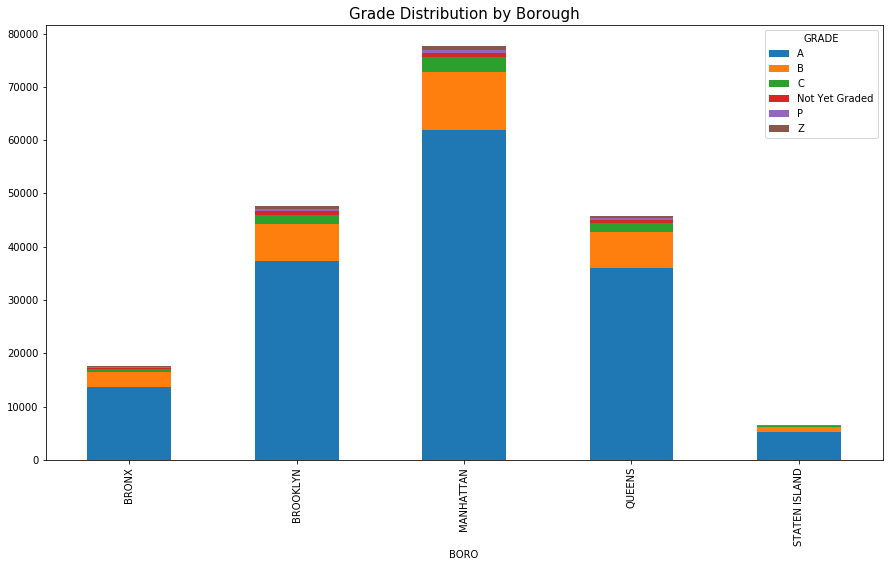

In [28]:
# Plot of grade by borough
pd.crosstab(data_df.BORO, data_df.GRADE).plot(kind="bar", figsize=(15,8), stacked=True)
plt.title('Grade Distribution by Borough', fontsize = 15);


Most of the grades are 'A' and since restaurants in manhattan are the most inspected, most of the 'A' grades are in manhattan.

Text(0.5,1,'Boxplot by Borough')

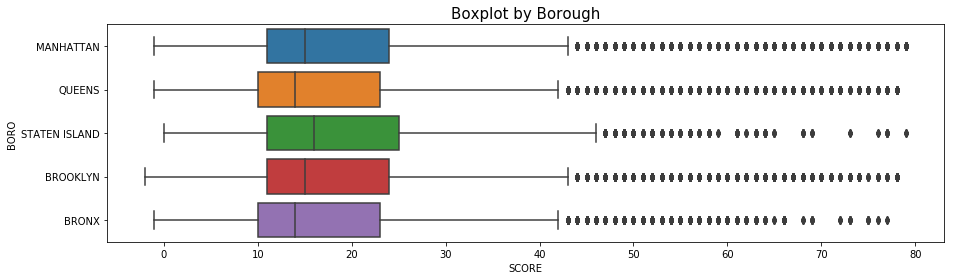

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
sns.boxplot(clean_scores.SCORE, clean_scores.BORO)
plt.title('Boxplot by Borough', fontsize = 15)


Every borough has more or less the same score distribution.

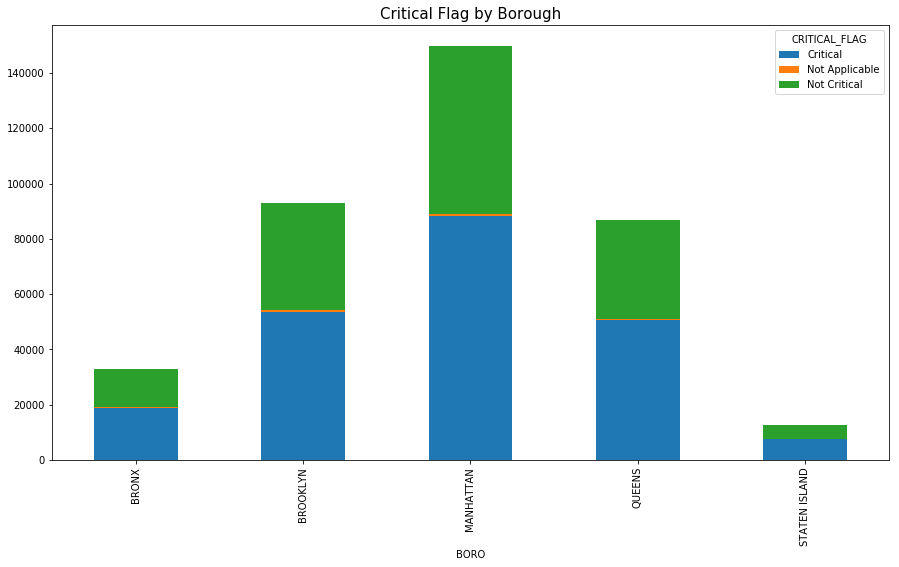

In [30]:
# Critical Flag by Borough
pd.crosstab(clean_scores.BORO, clean_scores['CRITICAL_FLAG']).plot(kind="bar", figsize=(15,8), stacked=True)
plt.title('Critical Flag by Borough', fontsize = 15);

Across borough the same distribution of critical flags and non critical in the same proportion.

# Analysis by cuisine

10 most popular cuisines per inspection

In [31]:
top_10_cuisine_inspection = clean_scores['CUISINE_DESCRIPTION'].value_counts()/len(clean_scores)*100
top_10_cuisine_inspection[0:10]

American                                                            22.706316
Chinese                                                             10.787898
Latin (Cuban, Dominican, Puerto Rican, South & Central American)     4.762197
Pizza                                                                4.694771
Italian                                                              4.415472
CafÃ©/Coffee/Tea                                                     3.896585
Mexican                                                              3.782520
Japanese                                                             3.652199
Caribbean                                                            3.271095
Bakery                                                               3.003257
Name: CUISINE_DESCRIPTION, dtype: float64

Looking at the score distribution per the top fixe cuisine.

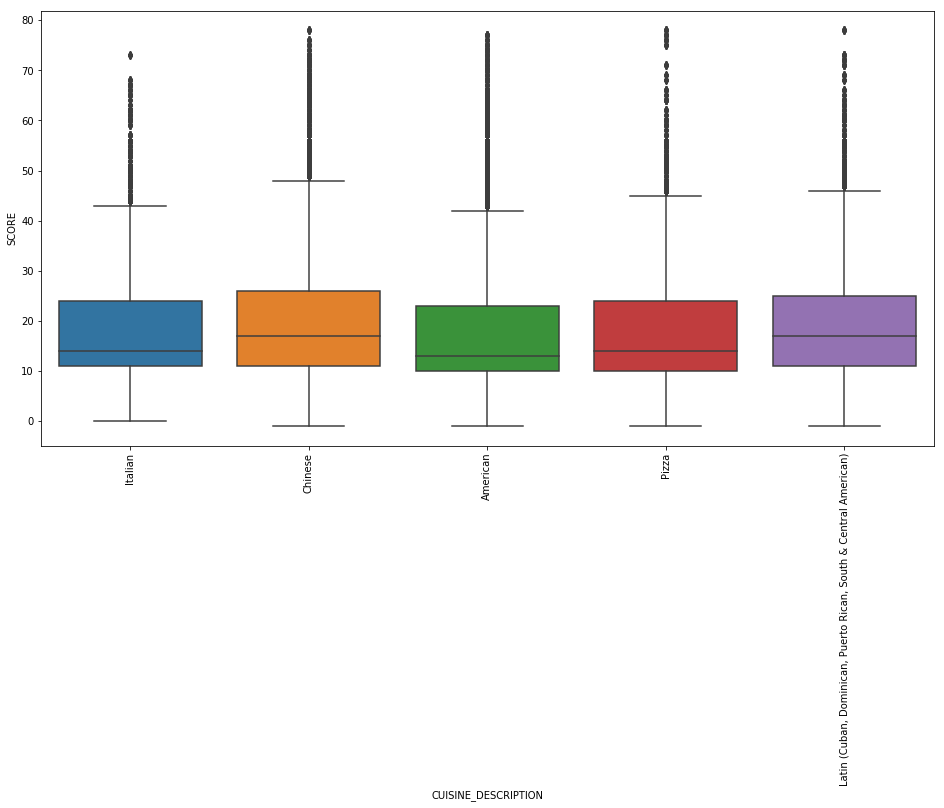

In [32]:
most_inspected_cuisine_list = ['American', 'Chinese', 'Latin (Cuban, Dominican, Puerto Rican, South & Central American)','Pizza', 'Italian']
most_inspected_cuisine = clean_scores[clean_scores['CUISINE_DESCRIPTION'].isin(most_inspected_cuisine_list)]
score_cuisine = pd.concat([most_inspected_cuisine['CUISINE_DESCRIPTION'], most_inspected_cuisine['SCORE']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x = 'CUISINE_DESCRIPTION', y="SCORE", data = score_cuisine)
plt.xticks(rotation=90);

The same scores with a slighter greater range for the chinese cuisine which translates as we saw previously to more B grades.

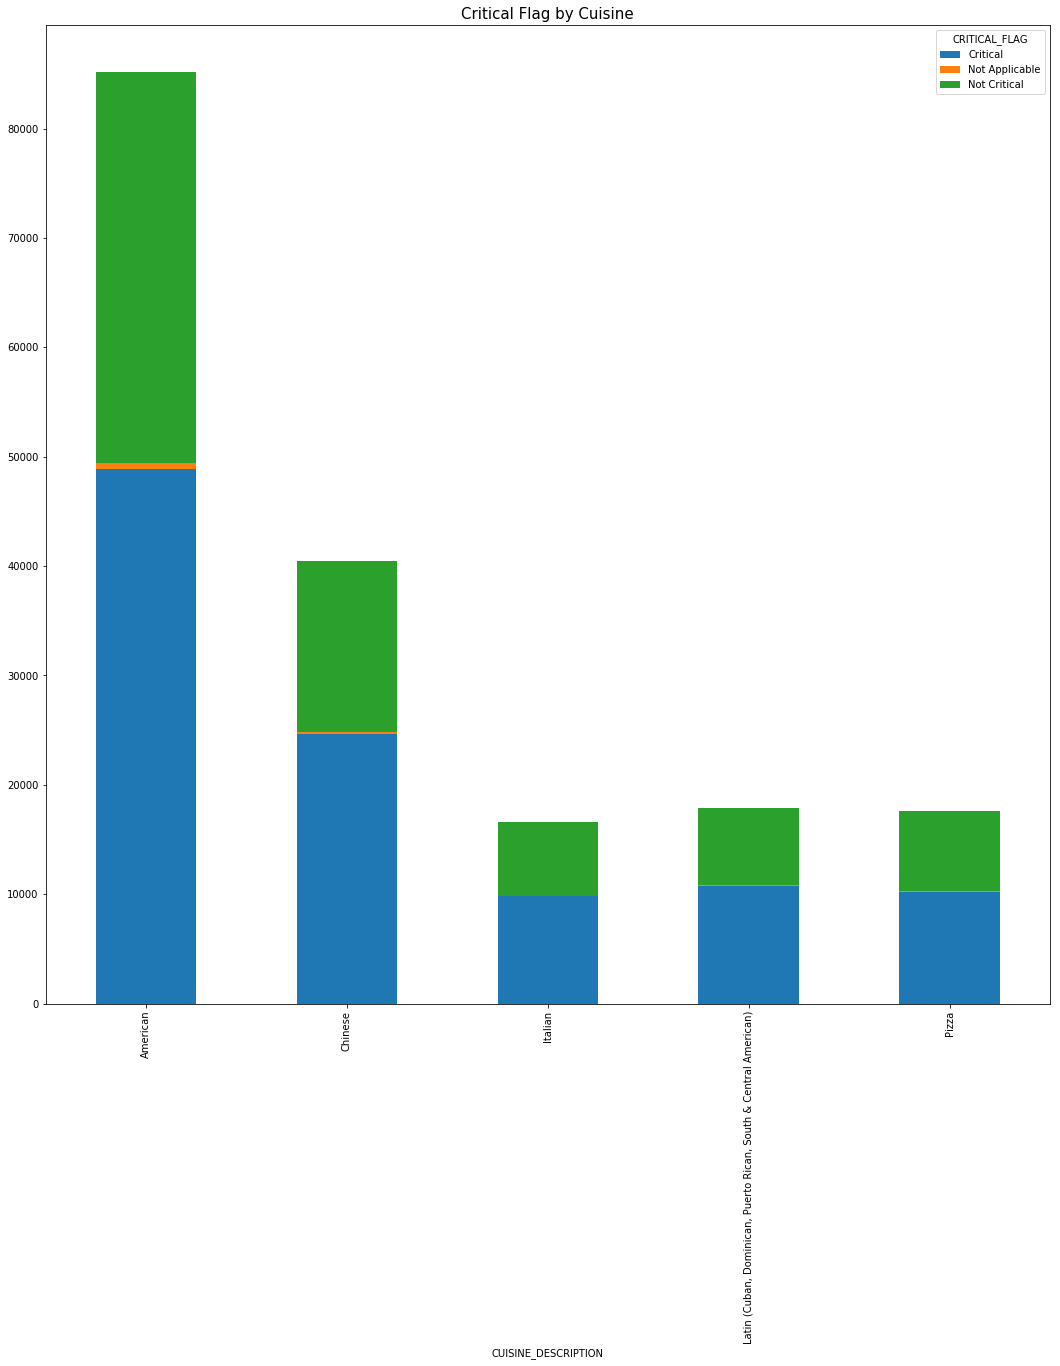

In [33]:
pd.crosstab(most_inspected_cuisine['CUISINE_DESCRIPTION'], most_inspected_cuisine['CRITICAL_FLAG']).plot(kind="bar", figsize=(18,18), stacked=True)
plt.title('Critical Flag by Cuisine', fontsize = 15);

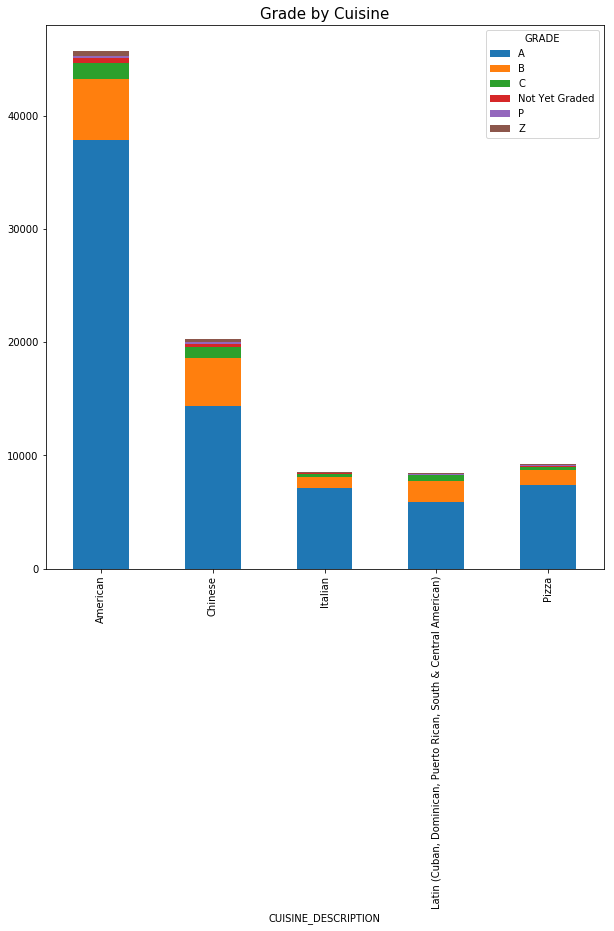

In [34]:
pd.crosstab(most_inspected_cuisine['CUISINE_DESCRIPTION'], most_inspected_cuisine['GRADE']).plot(kind="bar", figsize=(10,10), stacked=True)
plt.title('Grade by Cuisine', fontsize = 15);

Same regarding the critical vs. non critical flags, slightly more critical than non ones cross cuisine.

# Inspection

In [35]:
clean_scores['INSPECTION_TYPE'].value_counts()/len(clean_scores)*100

Cycle Inspection / Initial Inspection                      61.191389
Cycle Inspection / Re-inspection                           26.449393
Pre-permit (Operational) / Initial Inspection               6.493153
Pre-permit (Operational) / Re-inspection                    2.803910
Pre-permit (Non-operational) / Initial Inspection           1.035909
Cycle Inspection / Reopening Inspection                     0.858149
Cycle Inspection / Compliance Inspection                    0.382969
Inter-Agency Task Force / Initial Inspection                0.303817
Pre-permit (Operational) / Compliance Inspection            0.214537
Pre-permit (Operational) / Reopening Inspection             0.162302
Pre-permit (Non-operational) / Re-inspection                0.078353
Pre-permit (Operational) / Second Compliance Inspection     0.012259
Cycle Inspection / Second Compliance Inspection             0.007462
Pre-permit (Non-operational) / Compliance Inspection        0.002399
Trans Fat / Re-inspection         

Top five inspection types are: 
1. Cycle Inspection / Initial Inspection 
2. Cycle Inspection / Re-inspection
3. Pre-permit (Operational) / Initial Inspection
4. Pre-permit (Operational) / Re-inspection
5. Pre-permit (Non-operational) / Initial Inspection

In [36]:
clean_scores['ACTION'].value_counts()/len(clean_scores)*100

Violations were cited in the following area(s).                                                                                        96.561539
Establishment Closed by DOHMH.  Violations were cited in the following area(s) and those requiring immediate action were addressed.     2.146440
Establishment re-opened by DOHMH                                                                                                        0.710772
No violations were recorded at the time of this inspection.                                                                             0.364314
Establishment re-closed by DOHMH                                                                                                        0.216936
Name: ACTION, dtype: float64

Most common action on violation is : "Violations were cited in the following area(s)."

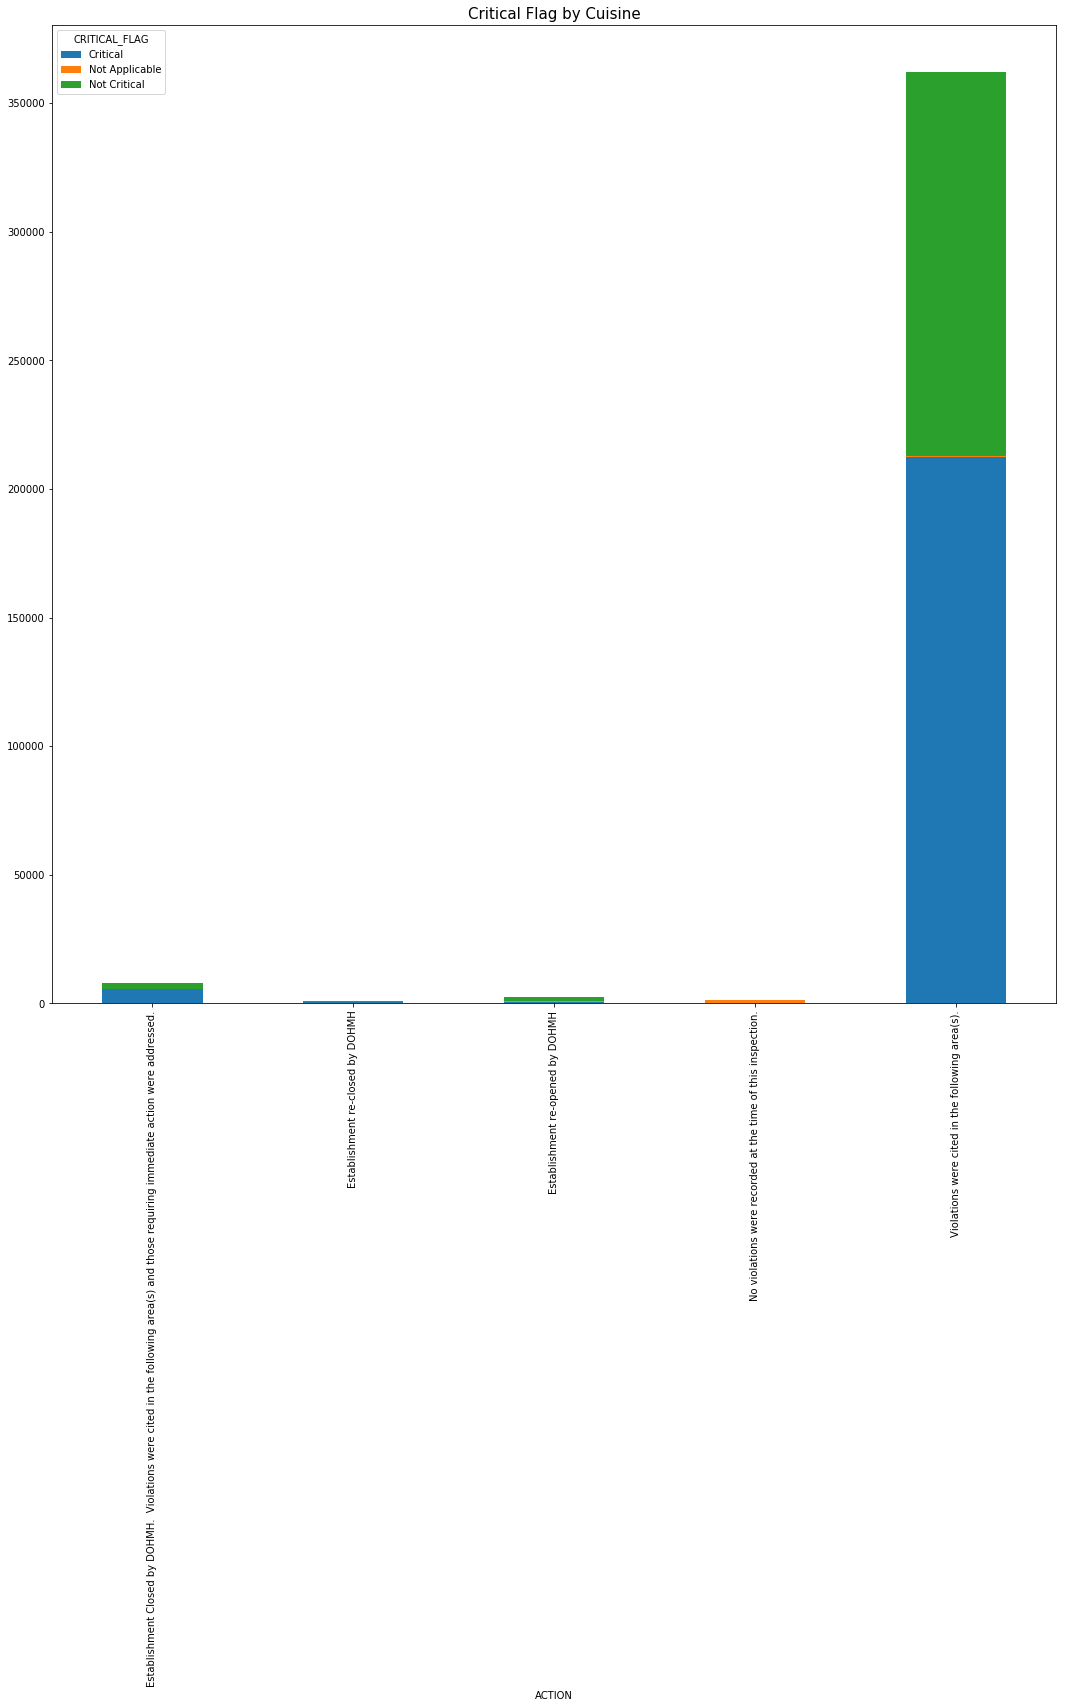

In [37]:
pd.crosstab(clean_scores['ACTION'], clean_scores['CRITICAL_FLAG']).plot(kind="bar", figsize=(18,18), stacked=True)
plt.title('Critical Flag by Cuisine', fontsize = 15);

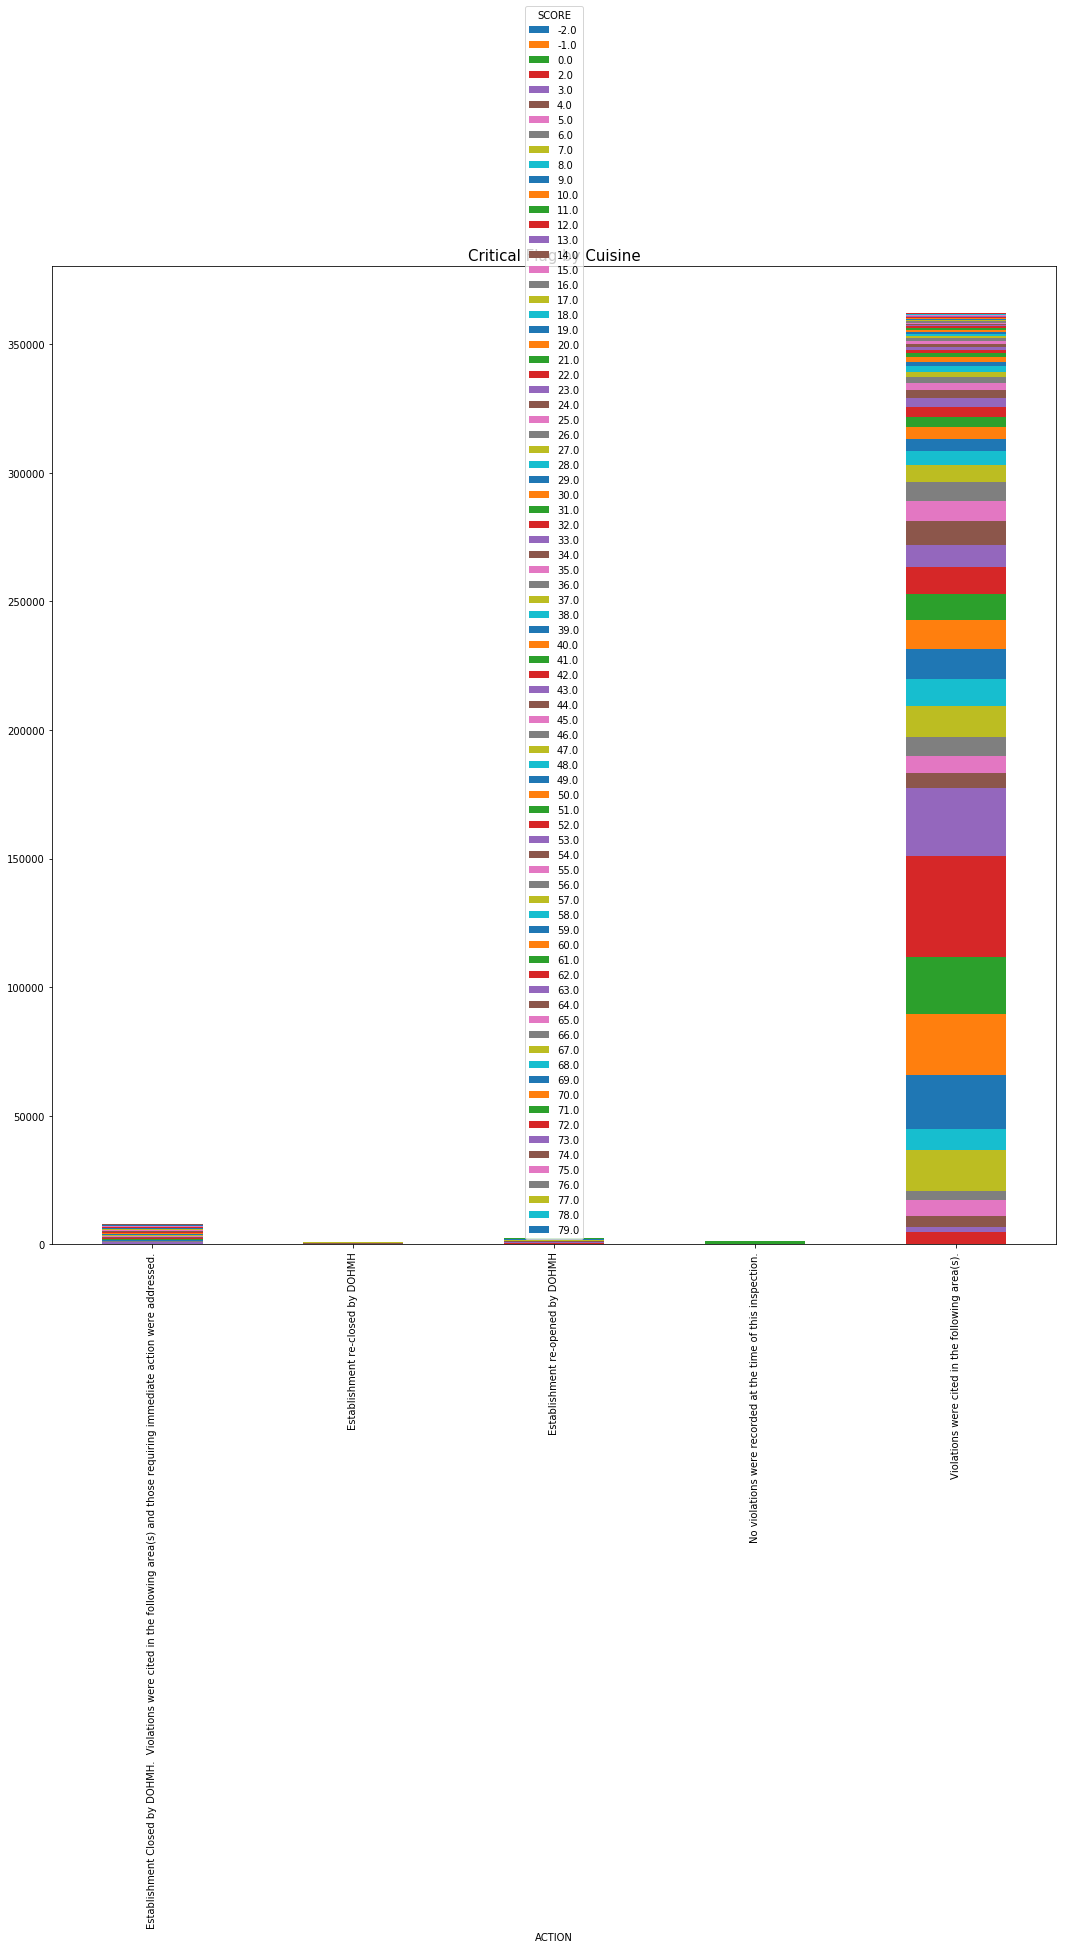

In [38]:
pd.crosstab(clean_scores['ACTION'], clean_scores['SCORE']).plot(kind="bar", figsize=(18,18), stacked=True)
plt.title('Critical Flag by Cuisine', fontsize = 15);

Most common violations:

In [39]:
clean_scores['VIOLATION_DESCRIPTION'].value_counts()/len(clean_scores)*100
    

Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.                                                                                             14.853981
Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.                                                                                                                                                                                                                                          10.622398
Cold food item held above 41Âº F (smoked fish and reduced oxygen packaged foods above 38 ÂºF) except during necessary preparation.                                                                                                                          

In [40]:
df_top_freq_offender = clean_scores.groupby(['DBA'])['VIO_TYPE'].agg(
    {"VIO_TYPE_count": len}).sort_values(
    "VIO_TYPE_count", ascending=False).head(15).reset_index()
df_top_freq_offender

,DBA,VIO_TYPE_count
0,DUNKIN' DONUTS,4102
1,SUBWAY,3584
2,MCDONALD'S,2700
3,STARBUCKS,2052
4,"DUNKIN' DONUTS, BASKIN ROBBINS",1412
5,DOMINO'S,1284
6,CROWN FRIED CHICKEN,1109
7,KENNEDY FRIED CHICKEN,1077
8,BURGER KING,1009
9,CHIPOTLE MEXICAN GRILL,925


Maybe better to avoid SUBWAY for a while. But the biggest offender is 'DUNKIN' DONUTS' or 'DUNKIN' DONUTS, BASKIN ROBBINS'.

When was the last inspection?

In [41]:
clean_scores.sort_values(by='INSPECTION_DATE', ascending=True)[:10]

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,ACTION,VIOLATION_CODE,...,CRITICAL_FLAG,SCORE,GRADE,INSPECTION_TYPE,VIO_LVL,VIO_TYPE,VIO_CAT,RECORD_DATE,INSPECTION_DATE,GRADE_DATE
163556,41611669,SMOKING TERECE,QUEENS,110-00,ROCKAWAY BOULEVARD,11420.0,7182153308,"Bottled beverages, including water, sodas, jui...",Violations were cited in the following area(s).,10J,...,Not Critical,2.0,NaN,Pre-permit (Non-operational) / Initial Inspection,10,J,9,2017-08-28,2011-10-07,NaT
343394,41606183,BEDFORD FUSION CAFE,BROOKLYN,197,BEDFORD AVENUE,11211.0,6467080446,Asian,No violations were recorded at the time of thi...,NaN,...,Not Applicable,0.0,NaN,Pre-permit (Non-operational) / Initial Inspection,99,No,94,2017-08-28,2011-12-30,NaT
111374,41611669,SMOKING TERECE,QUEENS,110-00,ROCKAWAY BOULEVARD,11420.0,7182153308,"Bottled beverages, including water, sodas, jui...",Violations were cited in the following area(s).,10F,...,Not Critical,7.0,A,Cycle Inspection / Initial Inspection,10,F,5,2017-08-28,2012-05-01,2012-05-01
197820,41611669,SMOKING TERECE,QUEENS,110-00,ROCKAWAY BOULEVARD,11420.0,7182153308,"Bottled beverages, including water, sodas, jui...",Violations were cited in the following area(s).,06D,...,Critical,7.0,A,Cycle Inspection / Initial Inspection,6,D,84,2017-08-28,2012-05-01,2012-05-01
266920,40962072,RARYTAS MANOR,QUEENS,5509,METROPOLITAN AVENUE,11385.0,7183267511,Eastern European,Violations were cited in the following area(s).,10H,...,Not Critical,2.0,A,Cycle Inspection / Initial Inspection,10,H,7,2017-08-28,2012-06-23,2012-06-23
16362,41641292,XL NIGHT CLUB,MANHATTAN,512,WEST 42 STREET,10036.0,2125292999,American,Violations were cited in the following area(s).,08A,...,Not Critical,36.0,NaN,Cycle Inspection / Initial Inspection,8,A,91,2017-08-28,2012-12-11,NaT
147537,41641292,XL NIGHT CLUB,MANHATTAN,512,WEST 42 STREET,10036.0,2125292999,American,Violations were cited in the following area(s).,04J,...,Critical,36.0,NaN,Cycle Inspection / Initial Inspection,4,J,67,2017-08-28,2012-12-11,NaT
389582,41641292,XL NIGHT CLUB,MANHATTAN,512,WEST 42 STREET,10036.0,2125292999,American,Violations were cited in the following area(s).,04A,...,Critical,36.0,NaN,Cycle Inspection / Initial Inspection,4,A,58,2017-08-28,2012-12-11,NaT
52627,41641292,XL NIGHT CLUB,MANHATTAN,512,WEST 42 STREET,10036.0,2125292999,American,Violations were cited in the following area(s).,06E,...,Critical,36.0,NaN,Cycle Inspection / Initial Inspection,6,E,85,2017-08-28,2012-12-11,NaT
390464,41641292,XL NIGHT CLUB,MANHATTAN,512,WEST 42 STREET,10036.0,2125292999,American,Violations were cited in the following area(s).,04N,...,Critical,36.0,NaN,Cycle Inspection / Initial Inspection,4,N,71,2017-08-28,2012-12-11,NaT


Avoid restaurants when the last inspection was more than 3 years.

In [42]:
clean_scores['INSPECTION_DATE_YEAR'] = pd.to_datetime(clean_scores['INSPECTION_DATE'])
clean_scores['INSPECTION_DATE_YEAR'] = clean_scores['INSPECTION_DATE_YEAR'].map(lambda x: x.date().year)

In [43]:
clean_scores[clean_scores.INSPECTION_DATE_YEAR<  2016]['DBA']

0                             NOTARO RESTAURANT
5                               KABAB HOUSE NYC
8                                  PLANET WINGS
9                                   TOMOE SUSHI
10                              YAKITORI TAISHO
11        GOLDEN KRUST CARIBBEAN BAKERY & GRILL
16                    NOM WAH TEA/DIM SUM PALOR
17                        LUIGI'S PIZZA & PASTA
18                         ANARKALI INDIAN FOOD
19                             MIDNIGHT EXPRESS
20                             NEW PANDA GARDEN
29                         ANABLE BASIN SAILING
30                                   MR. WONTON
31                                  BAGEL WORLD
33                             HAPPY RESTAURANT
34                                WOLF AND LAMB
36                        JUMBO CHINESE KITCHEN
38                          OLD SICHUAN CUISINE
39          HUDSON'S MARKET @ SHERATON NEW YORK
45               DUNKIN' DONUTS, BASKIN ROBBINS
49                                    CH

In [46]:
clean_scores[clean_scores['GRADE'] == 'A']

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,ACTION,VIOLATION_CODE,...,SCORE,GRADE,INSPECTION_TYPE,VIO_LVL,VIO_TYPE,VIO_CAT,RECORD_DATE,INSPECTION_DATE,GRADE_DATE,INSPECTION_DATE_YEAR
7,40807238,RICHMOND COUNTY COUNTRY CLUB,STATEN ISLAND,1122,TODT HILL ROAD,10304.0,7183510600,American,Violations were cited in the following area(s).,02G,...,12.0,A,Cycle Inspection / Initial Inspection,2,G,47,2017-08-28,2017-06-14,2017-06-14,2017
9,40376944,TOMOE SUSHI,MANHATTAN,172,THOMPSON STREET,10012.0,2127779346,Japanese,Violations were cited in the following area(s).,02G,...,13.0,A,Cycle Inspection / Re-inspection,2,G,47,2017-08-28,2015-10-06,2015-10-06,2015
12,41701178,CRAB SPOT RESTAURANT,BROOKLYN,833,UNION STREET,11215.0,7186222722,Seafood,Violations were cited in the following area(s).,09C,...,12.0,A,Cycle Inspection / Initial Inspection,9,C,97,2017-08-28,2016-07-28,2016-07-28,2016
13,41374557,M NOODLE SHOP,BROOKLYN,549,METROPOLITAN AVENUE,11211.0,7183848008,Chinese,Violations were cited in the following area(s).,08A,...,10.0,A,Cycle Inspection / Re-inspection,8,A,91,2017-08-28,2017-01-19,2017-01-19,2017
14,41688137,LOWER SUITES STOLI BAR SOUTH CLUB LOUNGE,BROOKLYN,620,ATLANTIC AVENUE,11217.0,9176186310,American,Violations were cited in the following area(s).,10F,...,4.0,A,Cycle Inspection / Initial Inspection,10,F,5,2017-08-28,2017-01-25,2017-01-25,2017
15,40570634,AN BEAL BOCHT CAFE,BRONX,445,WEST 238 STREET,10463.0,7188847127,American,Violations were cited in the following area(s).,10B,...,9.0,A,Cycle Inspection / Re-inspection,10,B,1,2017-08-28,2017-08-14,2017-08-14,2017
17,41696159,LUIGI'S PIZZA & PASTA,BRONX,119,EAST MOUNT EDEN AVENUE,10452.0,7182941800,Pizza,Violations were cited in the following area(s).,10B,...,13.0,A,Cycle Inspection / Re-inspection,10,B,1,2017-08-28,2014-10-27,2014-10-27,2014
22,41611667,SERVICE BAR 7,QUEENS,11000,ROCKAWAY BOULEVARD,11420.0,6465881074,American,Violations were cited in the following area(s).,10B,...,7.0,A,Cycle Inspection / Initial Inspection,10,B,1,2017-08-28,2016-04-07,2016-04-07,2016
26,50055935,TROPICAL REVIVAL RESTAURANT & CATERING,QUEENS,1240C,CLINTONVILLE ST,11357.0,9175637877,Caribbean,Violations were cited in the following area(s).,10F,...,2.0,A,Pre-permit (Operational) / Initial Inspection,10,F,5,2017-08-28,2016-11-15,2016-11-15,2016
27,41468267,ICHI UMI,MANHATTAN,6,EAST 32 STREET,10016.0,2127251333,Japanese,Violations were cited in the following area(s).,10B,...,12.0,A,Cycle Inspection / Re-inspection,10,B,1,2017-08-28,2016-09-26,2016-09-26,2016


In [78]:
clean_grades = data_df.dropna(axis=0, subset=['GRADE']) 
clean_grades.shape

(195413, 21)

In [79]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(np.unique(clean_grades['GRADE'].values))
le.classes_
clean_grades['GRADE_LABEL'] = le.transform(clean_grades['GRADE'])

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

data_X = clean_grades['VIO_CAT'].values
data_y = clean_grades['GRADE_LABEL'].values
#X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.25, random_state=42)

In [81]:
data_X[:3]

array([68, 47, 47], dtype=int8)

In [82]:
data_y[:3]

array([2, 0, 0])

In [83]:
classifier = DecisionTreeClassifier()
classifier.fit(data_X.reshape(-1, 1), data_y.reshape(-1, 1))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [88]:
nan_grades = data_df[data_df['GRADE'].isnull()]
nan_grades.shape

(204505, 21)

In [94]:
test_X = nan_grades['VIO_CAT'].values
nan_grades['GRADE'] = le.inverse_transform(classifier.predict(test_X.reshape(-1, 1)))

In [95]:
nan_grades[0:3]

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,ACTION,VIOLATION_CODE,...,CRITICAL_FLAG,SCORE,GRADE,INSPECTION_TYPE,VIO_LVL,VIO_TYPE,VIO_CAT,RECORD_DATE,INSPECTION_DATE,GRADE_DATE
0,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,Violations were cited in the following area(s).,02B,...,Critical,30.0,A,Cycle Inspection / Initial Inspection,2,B,42,2017-08-28,2015-06-15,NaT
1,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,Violations were cited in the following area(s).,20F,...,Not Critical,NaN,A,Administrative Miscellaneous / Initial Inspection,20,F,34,2017-08-28,2014-11-25,NaT
2,50046354,VITE BAR,QUEENS,2507,BROADWAY,11106.0,3478134702,Italian,Violations were cited in the following area(s).,10F,...,Not Critical,2.0,A,Pre-permit (Operational) / Initial Inspection,10,F,5,2017-08-28,2016-10-03,NaT
